In [13]:
from api_client import AutoJWTClient
from pprint import pprint
from dotenv import dotenv_values
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

config = dotenv_values(".env")
TEST_USER_PASSWORD = config.get('TEST_USER_PASSWORD')
TEST_USER_EMAIL = config.get('TEST_USER_EMAIL')

client = AutoJWTClient(
    base_url="https://osdarken.pythonanywhere.com/api",
    login_url="/auth/token/",
    email=TEST_USER_EMAIL,
    password=TEST_USER_PASSWORD
)

In [14]:
response = client.get('/medication/medication-logs/?date=month&ordering=date')
data = response.json()
pprint(response.json())

[{'date': '2025-07-01',
  'dose_taken': None,
  'dose_time': 25,
  'dose_unit': '',
  'id': 259,
  'medication': 1,
  'medication_name': 'Salmiden',
  'notes': '',
  'taken_status': 'taken',
  'taken_time': None,
  'time': '10:08:20.685513',
  'user': 1}]


In [15]:
from IPython.display import Markdown, display
from collections import defaultdict
from datetime import datetime

# Grup verisi (örnek veri burada tekrar tanımlı değilse tanımlamalısın)
grouped = defaultdict(list)
for entry in data:
    grouped[entry['date']].append(entry)

def format_time(raw_time):
    if not raw_time:
        return "-"
    try:
        return datetime.strptime(raw_time.split('.')[0], "%H:%M:%S").strftime("%H:%M:%S")
    except:
        return raw_time

# Markdown render
for date in sorted(grouped.keys(), reverse=True):
    md = f"\n### 📅 {date}\n\n"
    md += "| İlaç Adı | Durum | Saat | Doz Saati | Notlar |\n"
    md += "|----------|--------|-----------|-----------|--------|\n"
    for item in grouped[date]:
        name = item['medication_name']
        status = item['taken_status']
        time = format_time(item['time'])
        dose_time = item['dose_time'] if item['dose_time'] is not None else "-"
        notes = item['notes']
        md += f"| {name} | {status} | {time} | {dose_time} | {notes} |\n"
    display(Markdown(md))



### 📅 2025-07-01

| İlaç Adı | Durum | Saat | Doz Saati | Notlar |
|----------|--------|-----------|-----------|--------|
| Salmiden | taken | 10:08:20 | 25 |  |


# PANDAS ILE EXCEL CIKTISI

In [ ]:
!pip install pandas openpyxl

In [4]:
import pandas as pd
from collections import defaultdict
from datetime import datetime
from openpyxl import load_workbook
from openpyxl.styles import Font, Alignment
from openpyxl.utils import get_column_letter

def format_time(raw_time):
    if not raw_time:
        return "-"
    try:
        return datetime.strptime(raw_time.split('.')[0], "%H:%M:%S").strftime("%H:%M:%S")
    except:
        return raw_time

# Gruplama ve excel formatına uygun veri hazırlama
grouped = defaultdict(list)
for item in data:
    grouped[item['date']].append(item)

# Excel yazılacak veri yapısı (tarih başlığı + tablo verisi)
rows = []

for date in sorted(grouped.keys(), reverse=True):
    rows.append({"Tarih": f"📅 {date}", "İlaç Adı": "", "Durum": "", "Doz Saati": ""})
    for item in grouped[date]:
        rows.append({
            "Tarih": "",
            "İlaç Adı": item['medication_name'],
            "Durum": item['taken_status'],
            "Doz Saati": format_time(item['time']) if item['time'] is not None else "-",
        })
    rows.append({"Tarih": "", "İlaç Adı": "", "Durum": "", "Doz Saati": ""})  # boşluk satırı

# DataFrame oluştur
df = pd.DataFrame(rows)

# Excel'e yaz
excel_path = "ilac_takip_gelistirilmis.xlsx"
df.to_excel(excel_path, index=False)

# Genişlik ve stil ayarları
wb = load_workbook(excel_path)
ws = wb.active

# Otomatik sütun genişliği ve ortalama
for col in ws.columns:
    max_length = 0
    column = col[0].column_letter
    for cell in col:
        try:
            if cell.value:
                max_length = max(max_length, len(str(cell.value)))
        except:
            pass
    ws.column_dimensions[column].width = max_length + 4
    for cell in col:
        cell.alignment = Alignment(horizontal='center', vertical='center')
        if isinstance(cell.value, str) and cell.value.startswith("📅"):
            cell.font = Font(bold=True)

# Kaydet
wb.save(excel_path)

excel_path


'ilac_takip_gelistirilmis.xlsx'

---

# Sayaçlar

In [16]:
response = client.get('/counter/all/')
pprint(response.json())

[{'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-26', 'total': 1},
 {'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-27', 'total': 4},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-05-27', 'total': 2},
 {'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-28', 'total': 4},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-05-28', 'total': 1},
 {'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-29', 'total': 4},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-05-29', 'total': 2},
 {'counter_id': 3, 'counter_name': 'Mukus', 'date': '2025-05-30', 'total': 1},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-05-30', 'total': 3},
 {'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-30', 'total': 4},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-05-31', 'total': 2},
 {'counter_id': 1, 'counter_name': 'wc', 'date': '2025-05-31', 'total': 3},
 {'counter_id': 2, 'counter_name': 'kan', 'date': '2025-06-01', 'total': 3},
 {'

In [21]:
def reFrameData(data: list):
    colorMap: dict = {
        "kan": "red",
        "Mukus": "orange",
        "wc": "cyan"
    }
    for const in data:
        const["color"] = colorMap[const["counter_name"]]
    return data
data = reFrameData(response.json())

In [18]:
data

[{'date': '2025-05-26',
  'counter_id': 1,
  'counter_name': 'wc',
  'total': 1,
  'color': 'cyan'},
 {'date': '2025-05-27',
  'counter_id': 1,
  'counter_name': 'wc',
  'total': 4,
  'color': 'cyan'},
 {'date': '2025-05-27',
  'counter_id': 2,
  'counter_name': 'kan',
  'total': 2,
  'color': 'red'},
 {'date': '2025-05-28',
  'counter_id': 1,
  'counter_name': 'wc',
  'total': 4,
  'color': 'cyan'},
 {'date': '2025-05-28',
  'counter_id': 2,
  'counter_name': 'kan',
  'total': 1,
  'color': 'red'},
 {'date': '2025-05-29',
  'counter_id': 1,
  'counter_name': 'wc',
  'total': 4,
  'color': 'cyan'},
 {'date': '2025-05-29',
  'counter_id': 2,
  'counter_name': 'kan',
  'total': 2,
  'color': 'red'},
 {'date': '2025-05-30',
  'counter_id': 3,
  'counter_name': 'Mukus',
  'total': 1,
  'color': 'orange'},
 {'date': '2025-05-30',
  'counter_id': 2,
  'counter_name': 'kan',
  'total': 3,
  'color': 'red'},
 {'date': '2025-05-30',
  'counter_id': 1,
  'counter_name': 'wc',
  'total': 4,
  'co

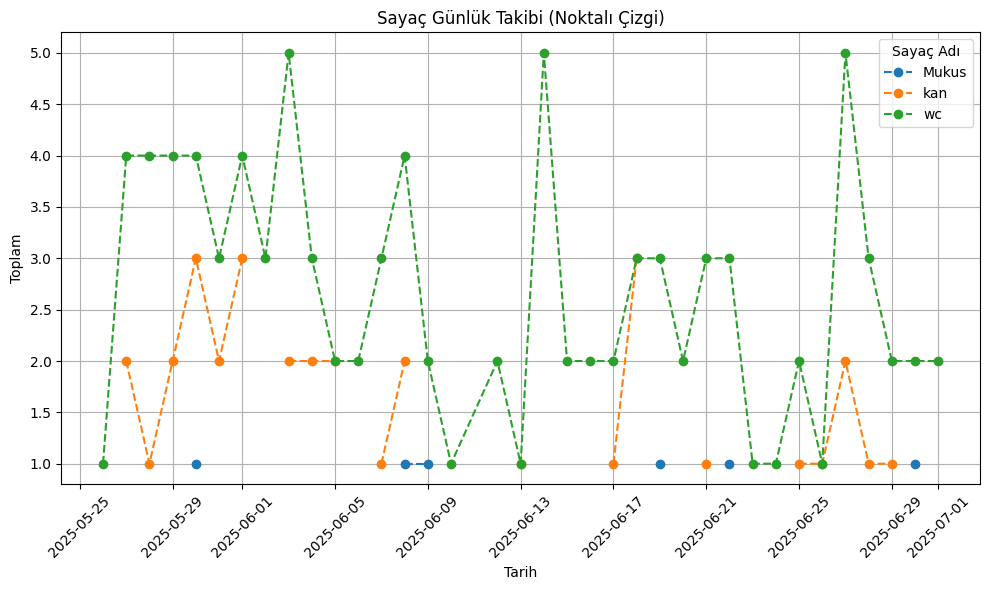

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# API'den gelen veri
data = response.json()

# DataFrame oluştur
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Pivot tablo
pivot_df = df.pivot_table(index='date', columns='counter_name', values='total', aggfunc='sum')

# Grafik çizimi
plt.figure(figsize=(10, 6))
for column in pivot_df.columns:
    plt.plot(
        pivot_df.index,
        pivot_df[column],
        linestyle='--',
        marker='o',
        label=column
    )

plt.title('Sayaç Günlük Takibi (Noktalı Çizgi)')
plt.xlabel('Tarih')
plt.ylabel('Toplam')
plt.grid(True)
plt.legend(title='Sayaç Adı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
from IPython.display import HTML

# DataFrame
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# Renkleri eşle (her counter_name için 1 renk seçiyoruz)
colors = df.drop_duplicates(subset='counter_name').set_index('counter_name')['color'].to_dict()

# Pivot
pivot_df = df.pivot_table(index='date', columns='counter_name', values='total', aggfunc='sum').fillna(0)
categories = pivot_df.index.strftime('%Y-%m-%d').tolist()

# Series ve renk listesi
series = []
color_list = []

for counter in pivot_df.columns:
    series.append({
        'name': counter,
        'data': pivot_df[counter].tolist()
    })
    color_list.append(colors.get(counter, '#000'))  # varsayılan siyah

# HTML + JS
html = f"""
<div id="chart"></div>
<script src="https://cdn.jsdelivr.net/npm/apexcharts"></script>
<script>
    var options = {{
        chart: {{
            type: 'line',
            height: 400
        }},
        colors: {color_list},
        series: {series},
        xaxis: {{
            categories: {categories}
        }},
        markers: {{
            size: 6
        }},
        stroke: {{
            curve: 'straight'
        }},
        title: {{
            text: 'Sayaç Takibi (Renkli)',
            align: 'left'
        }}
    }};

    var chart = new ApexCharts(document.querySelector("#chart"), options);
    chart.render();
</script>
"""

HTML(html)


In [23]:
from collections import defaultdict

# Sadece "wc" olanları filtrele
wc_data = [item for item in data if item['counter_name'] == 'wc']

# Tarihe göre grupla
wc_daily_totals = defaultdict(int)
for item in wc_data:
    wc_daily_totals[item['date']] += item['total']

# Günlük toplamların ortalamasını al
wc_daily_avg = sum(wc_daily_totals.values()) / len(wc_daily_totals)

print("WC sayaç günlük ortalaması:", wc_daily_avg)

WC sayaç günlük ortalaması: 2.6666666666666665


In [24]:
from collections import defaultdict

# Sayaçlara göre günlük toplamları tut
daily_totals_by_counter = defaultdict(lambda: defaultdict(int))

for item in data:
    name = item['counter_name']
    date = item['date']
    total = item['total']
    daily_totals_by_counter[name][date] += total

# Ortalama hesapla
averages_by_counter = {}
for name, date_totals in daily_totals_by_counter.items():
    avg = sum(date_totals.values()) / len(date_totals)
    averages_by_counter[name] = avg

print(averages_by_counter)

{'wc': 2.6666666666666665, 'kan': 1.7, 'Mukus': 1.0}
